In [290]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pylab 
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error
from pingouin import partial_corr
import statsmodels.api as sm
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
import itertools
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import scipy.stats as stats

## Introduction

In this notebook, the generalized linear model is chosen to build the model of house prices. This choice of distribution family is based on the observation of the distribution of the SalePrice. 

It worth mentioning that, because of the high dimensional property of the dataset, two main methods are used to reduce the dimensionality, one is to remove the parameters which has very low partial correlation with SalePrice and another one is to keep only the statistically significant parameters in the full model.

A question: why is PCA not used here? One of the reasons is that there is a lot of categorical data (discrete), and ordinary PCA tends to ignore the discreteness.

# Load the data

In [291]:
train = pd.read_csv(open("train.csv"))
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploratory analysis

## Use visual analysis to check for anormaly

The scatter plot shows that very few house prices are above 500k.

<AxesSubplot:xlabel='Id', ylabel='SalePrice'>

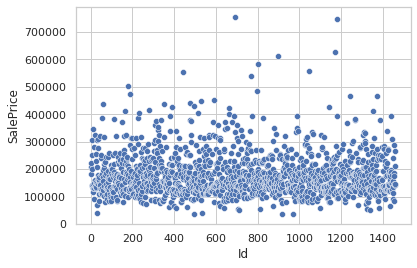

In [292]:
sns.scatterplot(data=train, x="Id", y="SalePrice")

The box plot shows that the Q3 quartile is at about 220k, and the prices abve about 330k are outliers. 

Regarding the interpretation of the box plot, I find [this](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51) very helpful.

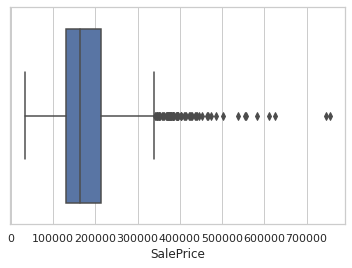

In [293]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=train["SalePrice"])

In [294]:
test = pd.read_csv(open("test.csv"))
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Check for typos or invalid variable names

We need to rename those variables, since they can cause a lot of syntactic problems latter.

In [295]:
# rename some of the columns 
to_replace = {'1stFlrSF': 'FirstFlrSF',
             '2ndFlrSF': 'SecondFlrSF',
             '3SsnPorch': 'ThreeSsnPorch'}
train.rename(columns=to_replace,
          inplace=True)
test.rename(columns=to_replace,
          inplace=True)

## Remove columns with too many missing values 

In this step we remove the columns with too many missing values. 

Note that we apply this step this to the testing data, because this method is supposed to help us determine which columns to use to do the prediction.

In [296]:
details = pd.DataFrame(train)
details.isnull().sum()

# delete the columns with as least a% missing value
def remove_missing_value(a, df):
    return train.loc[:, pd.notnull(df).sum() > len(train)*a]

a = 0.5
train = remove_missing_value(a, train)

In [297]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
cat_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

## Missing value handling

We use KNN imputing.

In [298]:
# deal with the mssing value
# replace Na by "Unknow" in each categorical column
# train.dtypes[train.dtypes == 'object'].index
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

In [299]:
# convert the object to categorical data
train[cat_cols] = train[cat_cols].astype('category')
train.dtypes

test[cat_cols] = test[cat_cols].astype('category')
test.dtypes

Id                  int64
MSSubClass          int64
MSZoning         category
LotFrontage       float64
LotArea             int64
                   ...   
MiscVal             int64
MoSold              int64
YrSold              int64
SaleType         category
SaleCondition    category
Length: 80, dtype: object

In [300]:
# check if there are null values in numerical data
num_cols = train.columns.difference(cat_cols)
train[num_cols].isnull().values.any()

True

In [301]:
# print how many null values are there in each column
train[num_cols].isnull().sum()

BedroomAbvGr       0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtFullBath       0
BsmtHalfBath       0
BsmtUnfSF          0
EnclosedPorch      0
Fireplaces         0
FirstFlrSF         0
FullBath           0
GarageArea         0
GarageCars         0
GarageYrBlt       81
GrLivArea          0
HalfBath           0
Id                 0
KitchenAbvGr       0
LotArea            0
LotFrontage      259
LowQualFinSF       0
MSSubClass         0
MasVnrArea         8
MiscVal            0
MoSold             0
OpenPorchSF        0
OverallCond        0
OverallQual        0
PoolArea           0
SalePrice          0
ScreenPorch        0
SecondFlrSF        0
ThreeSsnPorch      0
TotRmsAbvGrd       0
TotalBsmtSF        0
WoodDeckSF         0
YearBuilt          0
YearRemodAdd       0
YrSold             0
dtype: int64

In [302]:
# check if the numerical data is in the valid range
(train[num_cols] < 0).any()

BedroomAbvGr     False
BsmtFinSF1       False
BsmtFinSF2       False
BsmtFullBath     False
BsmtHalfBath     False
BsmtUnfSF        False
EnclosedPorch    False
Fireplaces       False
FirstFlrSF       False
FullBath         False
GarageArea       False
GarageCars       False
GarageYrBlt      False
GrLivArea        False
HalfBath         False
Id               False
KitchenAbvGr     False
LotArea          False
LotFrontage      False
LowQualFinSF     False
MSSubClass       False
MasVnrArea       False
MiscVal          False
MoSold           False
OpenPorchSF      False
OverallCond      False
OverallQual      False
PoolArea         False
SalePrice        False
ScreenPorch      False
SecondFlrSF      False
ThreeSsnPorch    False
TotRmsAbvGrd     False
TotalBsmtSF      False
WoodDeckSF       False
YearBuilt        False
YearRemodAdd     False
YrSold           False
dtype: bool

The same logic as how we dealt with the categorical features. We replace the null values using a value which has never appeared in the data, just like a "new category".

In [303]:
train[["GarageYrBlt", "LotFrontage"]]
# impute the missing data using -100, which is very different from the other data
train[num_cols] = train[num_cols].fillna(0)
# train[num_cols].isnull().sum(), just to check if it works

num_cols_test = num_cols.drop('SalePrice')
test[num_cols_test] = test[num_cols_test].fillna(0)

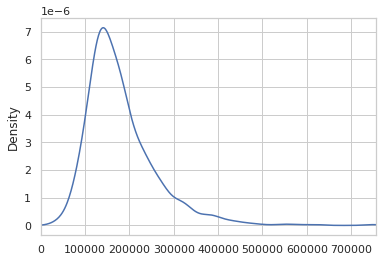

In [304]:
# check the distribution of the SalePrice
import matplotlib.pyplot as plt

train.SalePrice.plot(kind='density')

plt.xlim([0, max(train.SalePrice)])
plt.show()

In [305]:
# check the descriptive statistics
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [306]:
# encode the categorical data
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
# label encoding on multiple columns
train.loc[:, cat_cols] = train[cat_cols].apply(labelencoder.fit_transform)

test.loc[:, cat_cols] = test[cat_cols].apply(labelencoder.fit_transform)

In [239]:
# KNN 
def missing_value_handling_cat2(df):
    imputer = KNNImputer(n_neighbors=5)
    imputer.fit_transform(df[cat_cols])
    
missing_value_handling_cat2(train)

## Outlier detection

In [240]:
# outlier detection
iso = IsolationForest(n_estimators=10, warm_start=True)
out_pred = iso.fit_predict(train)
selector = out_pred != -1

selected_idxs = list(itertools.compress(train.index, selector))
train = train.iloc[selected_idxs, :]

In [242]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,...,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,...,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,3,0,4,...,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,3,0,0,...,272,0,0,0,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,3,0,2,...,0,0,0,0,0,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,3,3,0,4,...,0,0,0,0,0,8,2007,8,4,175000
1456,1457,20,3,85.0,13175,1,3,3,0,4,...,0,0,0,0,0,2,2010,8,4,210000
1457,1458,70,3,66.0,9042,1,3,3,0,4,...,0,0,0,0,2500,5,2010,8,4,266500
1458,1459,20,3,68.0,9717,1,3,3,0,4,...,112,0,0,0,0,4,2010,8,4,142125


# Correlation and partial correlation

After encoding, we can check the correlation. Since there are a lot of features, the heatmap looks quite messy. What we are interest in are the correlations between SalePrice and other parameters. And from the plot we can see that there is correlation between the other parameters. Therefore it makes sense that we explore also the partial correlation.

<AxesSubplot:>

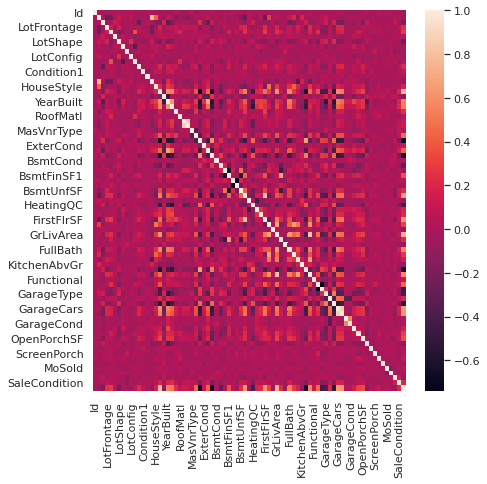

In [243]:
plt.figure(figsize = (7, 7))
corr_mat = train.corr()
sns.heatmap(corr_mat)

The value of the partial correlation ranges from -1 to 1 (inclusive), where 1 indicates a perfect positive correlation (like y = kx).

<AxesSubplot:>

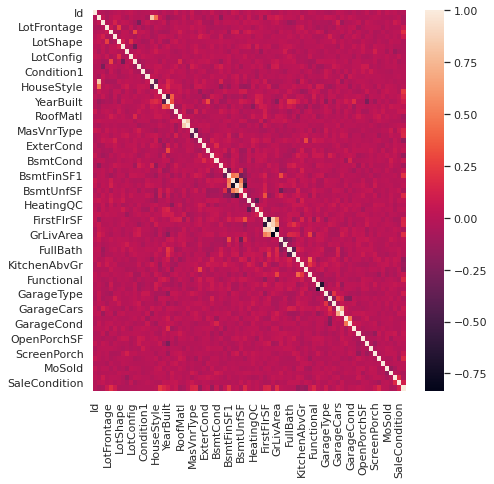

In [244]:
pcorr_mat = train.pcorr()
plt.figure(figsize = (7, 7))
sns.heatmap(pcorr_mat)

In [245]:
threshold = 0.035
rel_rows = pcorr_mat[abs(pcorr_mat["SalePrice"]) > threshold]["SalePrice"].index
rel_lst = list(rel_rows)
len(rel_lst)

44

# Generalized linear model (GLM)

This is the part where we actually begin to do the modeling. GLM seems to be more reasonable than ordinary linear regression (OLR), since the distribution of the `SalePrice` doesn't look quite Gaussian.

Firstly, we build a full model as baseline.

In [246]:
params_all = list(train.columns)
# Id doesn't have influence on the sale price
params_all.remove('Id')
# SalePrice is response variable
params_all.remove('SalePrice')

params_all = " + ".join(params_all)

formula = "SalePrice ~ " + params_all

# might also try inverse Gaussian distribution latter
model_full = sm.formula.glm(formula=formula, family=sm.families.Gamma(link=sm.genmod.families.links.log()), data=train).fit()
print(model_full.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1332
Model:                            GLM   Df Residuals:                     1258
Model Family:                   Gamma   Df Model:                           73
Link Function:                    log   Scale:                        0.011237
Method:                          IRLS   Log-Likelihood:                -14935.
Date:                Wed, 09 Feb 2022   Deviance:                       14.602
Time:                        12:01:46   Pearson chi2:                     14.1
No. Iterations:                    13   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.8911      4.615      3.877

Now we building a reduced model using the result of partial correlation. After trying several threshold values manually of the partial correlation, we notice that this doesn't really help us we reducing the AIC of the model. However, this might still help with reducing potential overfitting. 

But of course, the method of selecting the best threshold value can be more elegant.

In [247]:
pred_train = model_full.predict(train)
pred_train

real_train = train.SalePrice

In [248]:
print(model_full.aic)

30017.038374799773


In [249]:
msle = mean_squared_log_error(real_train, pred_train)
msle

0.011297983527275408

In [250]:
param_red = rel_lst
param_red.remove('SalePrice')
params_red = " + ".join(param_red)

formula_red = "SalePrice ~ " + params_red

model_red = sm.formula.glm(formula=formula_red, family=sm.families.Gamma(link=sm.genmod.families.links.log()), data=train).fit()
print(model_red.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1332
Model:                            GLM   Df Residuals:                     1289
Model Family:                   Gamma   Df Model:                           42
Link Function:                    log   Scale:                        0.011811
Method:                          IRLS   Log-Likelihood:                -14987.
Date:                Wed, 09 Feb 2022   Deviance:                       15.802
Time:                        12:01:54   Pearson chi2:                     15.2
No. Iterations:                    14   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        16.7272      4.604      3.633

In [251]:
print(model_red.aic)

30059.971221654403


In [252]:
pred_train_red = model_red.predict(train)
pred_train_red

real_train_red = train.SalePrice

In [253]:
msle = mean_squared_log_error(real_train_red, pred_train_red)
msle

0.012261724543717508

Try to build another simpler model with only statistically significant parameters (we set to thereshold of p-value to be 0.05).

In [277]:
param_p = ['MSZoning', 'LotArea', 'Street', 'LandContour', 'OverallQual', 'OverallCond', 'YearBuilt', 
           'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtCond', 
           'BsmtFinSF1', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'FirstFlrSF', 'SecondFlrSF', 
           'GrLivArea', 'BsmtFullBath', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 
           'GarageCars', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch', 'PoolArea', 
           'YrSold','SaleCondition']
params_p = " + ".join(param_p)
formula_p = "SalePrice ~ " + params_p
model_p = sm.formula.glm(formula=formula_p, family=sm.families.Gamma(link=sm.genmod.families.links.log()), data=train).fit()
print(model_p.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1332
Model:                            GLM   Df Residuals:                     1298
Model Family:                   Gamma   Df Model:                           33
Link Function:                    log   Scale:                        0.011541
Method:                          IRLS   Log-Likelihood:                -14972.
Date:                Wed, 09 Feb 2022   Deviance:                       15.451
Time:                        19:46:16   Pearson chi2:                     15.0
No. Iterations:                    14   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.9564      4.553      3.944

In [278]:
print(model_p.aic)

30011.998558753847


In [279]:
pred_train_p = model_p.predict(train)
pred_train_p

real_train_p = train.SalePrice

## Diagnostics

Pick one model and diagnose it. (here we use the full model)

In [286]:
yhat = pred_train
y = train.SalePrice
model = model_full

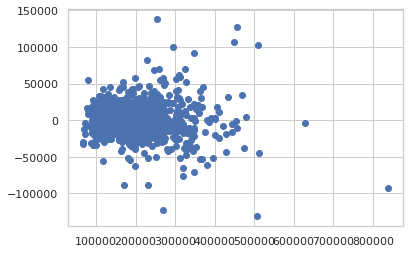

In [285]:
# residual vs. fitted
residuals = y - yhat

plt.scatter(yhat, residuals)
plt.show()

In the above plot, the residuals don't randomly bounce around zero, most of the residuals are no larger than 50k, and very huge. 

The plot looks very clustered, this might be misleading, since there are very few extremely high prices.

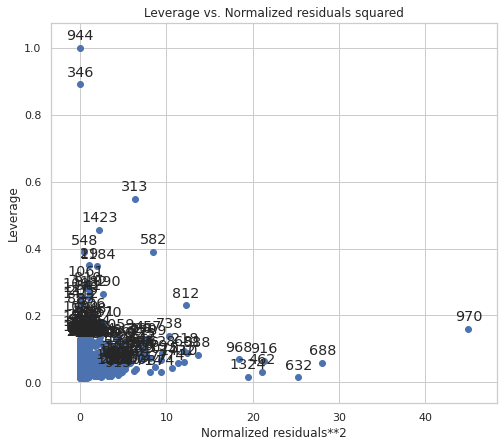

In [281]:
# leverage plot
fig, ax = plt.subplots(figsize=(8, 7))
fig = plot_leverage_resid2(model_full, ax=ax)

A lot of influential data points.

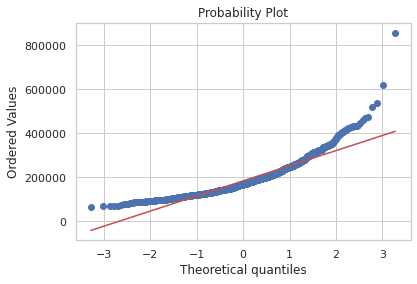

In [282]:
# Q-Q plot. The theoretical distribution is Gamma distribution
stats.probplot(yhat, dist="norm", plot=pylab)
pylab.show()

# Prediction using the test data

In [289]:
pred_test = model_full.predict(test)
pred_test

index = list(range(1461, 2920))
data = {"Id" : index, "SalePrice": pred_test}

result = pd.DataFrame(data)
result.to_csv("submission.csv", index=False)

Result: the model which gives the best prediction result is the full model without outlier removal.